# TensorFlow Tutorial - 3

## Keras API

### Introduction

Tutorial-2 showed how to implement a CNN in TensorFlow. We made a few helper-functions for creating the layers in the network. It is essential to have a good high-level API because it makes it much easier to implement complex models, and it lowers the risk of errors. 

There are several of these builder API's available for TensorFlow: PrettyTensor, Layers API and several others. 

This tutorial is about the Keras API which is already highly developed with very good documentation - and the development continues.  It seems likely that Keras will be the standard API for TensorFlow in the future so it is recommended that you use it instead of the other APIs.

The author of Keras has written a [blog-post](https://blog.keras.io/user-experience-design-for-apis.html) on his API design philosophy which you should read.

### Flowchart

The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below. See tutorial-2 for a more detailed description of convolution. 

There are two convolutional layers, each followed by a down-sampling using max-pooling. Then there are two filly-connected layers ending in a softmax-classifier. 


### Fashion-MNIST Data set

Again, we would be using the Fashion MNIST data set from the previous tensorflow tutorial. 

The Fashion-MNIST dataset contains Zalando's article images, with 28x28 grayscale images of 65,000 fashion products from 10 categories, and 6,500 images per category. The training set has 55,000 images, and the test set has 10,000 images. 

#### Loading the data

In [1]:
from keras.datasets import fashion_mnist

(df_train_X, df_train_Y), (df_test_X, df_test_Y) = fashion_mnist.load_data()

Using TensorFlow backend.


#### Lets Analyze the data set:

In [2]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape: ', df_train_X.shape, df_train_Y.shape)
print('Testing data shape: ', df_test_X.shape, df_test_Y.shape)

Training data shape:  (60000, 28, 28) (60000,)
Testing data shape:  (10000, 28, 28) (10000,)


#### Importing TensorFlow and Keras modules

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

import keras 
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [4]:
tf.__version__

'1.11.0'

#### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [15]:
# The number of pixels in each dimension of an image.
img_size = df_train_X.shape

# The images are stored in one-dimensional arrays of this length.
img_size_flat = 60000*28*28

# Tuple with height and width of images used to reshape arrays.
img_shape = (df_train_X.shape[1], df_train_X.shape[2]) 

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = df_train_X.shape

classes = np.unique(df_train_Y)
nClasses = len(classes)

# Number of classes, one class for each of 10 digits.
num_classes = nClasses

In [16]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Plot a few images to see if data is correct

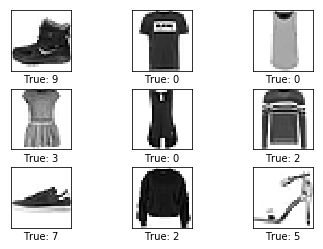

In [17]:
# Get the first images from the test-set.
images = df_train_X[0:9]

# Get the true classes for those images.
cls_true = df_train_Y[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

#### Helper-function to plot example errors

Function for plotting examples of images from the test-set that have been mis-classified.


In [18]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != df_test_X)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = df_test_X[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = df_test_Y[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

#### Functional Model

The Keras API can be used to construct more complicated networks using the functional model. Here, each call to the Keras API will create and return an instance that is itself callable. It is not clear whether it is a function or an object - but we can call it as if it is a function. 

Let's do some data processing before we start working on the model.

In [22]:
df_train_X = df_train_X.reshape(-1, 28, 28, 1)
df_test_X  = df_test_X.reshape(-1, 28, 28, 1)

df_train_X.shape, df_test_X.shape

df_train_X = df_train_X.astype('float32')
df_test_X  = df_test_X.astype('float32')

df_train_X = df_train_X / 255
df_test_X  = df_test_X / 255

# change the labels from categorical to one-hot encoding:
df_train_Y_one_hot = to_categorical(df_train_Y)
df_test_Y_one_hot  = to_categorical(df_test_Y)

# display the change for category label
print('Original label: ', df_train_Y[8])
print('After conversion to one-hot: ', df_train_Y_one_hot[8])

from sklearn.model_selection import train_test_split

df_train_X, df_valid_X, df_train_label, df_valid_label = train_test_split(df_train_X, 
                                                                          df_train_Y_one_hot, 
                                                                          test_size=0.2, 
                                                                         random_state=13)

Original label:  5
After conversion to one-hot:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [23]:
df_train_X.shape, df_valid_X.shape, df_train_label.shape, df_valid_label.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

Let's take more about the architecture:

First layer: Conv2D:

We are using this function because we are working with images.

Second Layer: Leaky ReLU:

We are using leaky relu because we need a non-linear decision boundary that could separate our 10 classes which are not linearly separable.

More specifically, you add Leaky ReLUs because they attempt to fix the problem of dying Rectified Linear Units (ReLUs). The ReLU activation function is used a lot in neural network architectures and more specifically in convolutional networks, where it has proven to be more effective than the widely used logistic sigmoid function.

As of 2017, this activation function is the most popular one for deep neural networks. The ReLU function allows the activation to be thresholded at zero. However, during the training, ReLU units can "die". This can happen when a large gradient flows through a ReLU neuron: it can cause the weights to update in such a way that the neuron will never activate on any data point again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. Leaky ReLUs attempt to solve this: the function will not be zero but will instead have a small negative slope.

Third Layer: MaxPooling2D()

The last layer is a Dense layer that has a softmax activation function with 10 units, which is needed for this multi-class classification problem.

In [62]:
batch_size = 128
epochs = 50
num_classes = 10

inputs = Input(shape=(28,28,1))

cnn_model = Conv2D(32, 
                     kernel_size=(3,3), 
                     activation='linear', 
                     input_shape=(28,28,1),
                     padding='same')(inputs)

cnn_model = LeakyReLU(alpha=0.1)(cnn_model)

cnn_model = MaxPooling2D((2,2),padding='same')(cnn_model)

cnn_model = Conv2D(64, (3,3), activation='linear',padding='same')(cnn_model)

cnn_model = LeakyReLU(alpha=0.1)(cnn_model)

cnn_model = MaxPooling2D((2,2),padding='same')(cnn_model)

cnn_model = Conv2D(128, (3,3), activation='linear',padding='same')(cnn_model)

cnn_model = LeakyReLU(alpha=0.1)(cnn_model)

cnn_model = MaxPooling2D(pool_size=(2,2),padding='same')(cnn_model)

cnn_model = Flatten()(cnn_model)

cnn_model = Dense(128, activation='linear')(cnn_model)

cnn_model = LeakyReLU(alpha=0.1)(cnn_model)

cnn_model = Dense(num_classes, activation='softmax')(cnn_model)

outputs = cnn_model

#### Compile the model

We have now defined the architecture of the model with its input and output. We now have to create a Keras model and compile it with a loss-function and optimizer, so it is ready for training.

Create a new instance of the Keras Functional Model. We give it the inputs and outputs of the Convolutional Neural Network that we constructed above.

In [63]:
model2 = Model(inputs=inputs, outputs=outputs)

Compile the Keras model using the RMSprop optimizer and with a loss-function for multiple categories. The only performance metric we are interested in is the classification accuracy, but you could use a list of metrics here.

In [64]:
model2.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [65]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 64)          0         
__________

##### Training

The model has now been defined and compiled so it can be trained using the same fit() function as used in the Sequential Model above. This also takes numpy-arrays as input.

In [66]:
cnn_train =  model2.fit(x=df_train_X,
                      y=df_train_label,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(df_valid_X, df_valid_label))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 3s 68us/step - loss: 0.5216 - acc: 0.8103 - val_loss: 0.3611 - val_acc: 0.8742
Epoch 2/50
48000/48000 [==============================] - 3s 59us/step - loss: 0.3144 - acc: 0.8858 - val_loss: 0.2977 - val_acc: 0.8943
Epoch 3/50
48000/48000 [==============================] - 3s 59us/step - loss: 0.2645 - acc: 0.9040 - val_loss: 0.2623 - val_acc: 0.9067
Epoch 4/50
48000/48000 [==============================] - 3s 59us/step - loss: 0.2300 - acc: 0.9153 - val_loss: 0.2582 - val_acc: 0.9077
Epoch 5/50
48000/48000 [==============================] - 3s 59us/step - loss: 0.2088 - acc: 0.9224 - val_loss: 0.2321 - val_acc: 0.9157
Epoch 6/50
48000/48000 [==============================] - 3s 59us/step - loss: 0.1837 - acc: 0.9325 - val_loss: 0.2397 - val_acc: 0.9147
Epoch 7/50
48000/48000 [==============================] - 3s 59us/step - loss: 0.1699 - acc: 0.9381 - val_loss: 0.2303 - val_acc

Finally! You trained the model on fashion-MNIST for 50 epochs, and by observing the training accuracy and loss, you can say that the model did a good job since after 50 epochs the training accuracy is 99.43% and the training loss is quite low.

However, it looks like the model is overfitting, as the validation loss is 0.6083 and the validation accuracy is 91.74%.

Overfitting gives an intuition that the network has memorized the training data very well but is not guaranteed to work on unseen data, and that is why there is a difference in the training and validation accuracy.

#### Model Evaluation:

Lets evaluate our model over test data to see how it performs.

In [67]:
test_eval = model2.evaluate(df_test_X, df_test_Y_one_hot, verbose=0)

In [68]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.5830869729827507
Test accuracy: 0.9158


The test accuracy looks impressive. It turns out that your classifier does better than the benchmark that was reported, which is an SVM classifier with mean accuracy of 0.897. Also, the model does well compared to some of the deep learning models mentioned on the GitHub profile of the creators of fashion-MNIST dataset.


Let's put our model evaluation into plots of accuracy vs loss between training and validation data:

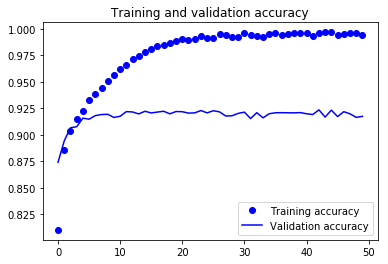

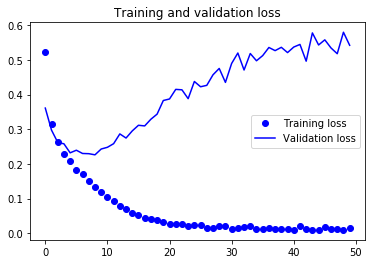

In [69]:
accuracy = cnn_train.history['acc']
val_accuracy = cnn_train.history['val_acc']
loss = cnn_train.history['loss']
val_loss = cnn_train.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Predict Labels

Since the predictions you get are floating point values, it will not be feasible to compare the predicted labels with true test labels. So, you will round off the output which will convert the float values into an integer. Further, you will use np.argmax() to select the index number which has a higher value in a row.

In [70]:
predicted_classes = model2.predict(df_test_X)

In [71]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [72]:
predicted_classes.shape, df_test_X.shape

((10000,), (10000, 28, 28, 1))

Found 9158 correct labels


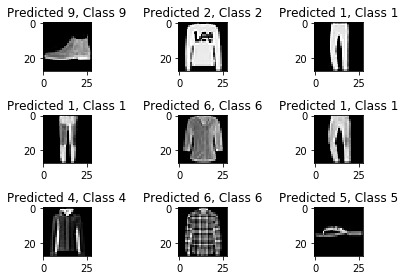

In [73]:
correct = np.where(predicted_classes==df_test_Y)[0]
print ("Found %d correct labels" % len(correct))

for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(df_test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], df_test_Y[correct]))
    plt.tight_layout()


Found 842 incorrect labels


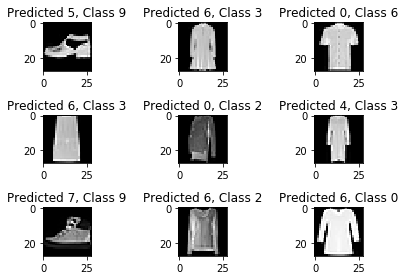

In [74]:
incorrect = np.where(predicted_classes!=df_test_Y)[0]
print ("Found %d incorrect labels" % len(incorrect))

for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(df_test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], df_test_Y[incorrect]))
    plt.tight_layout()

By looking at a few images, you cannot be sure as to why your model is not able to classify the above images correctly, but it seems like a variety of the similar patterns present on multiple classes affect the performance of the classifier although CNN is a robust architecture. For example, images 5 and 6 both belong to different classes but look kind of similar maybe a jacket or perhaps a long sleeve shirt.